In [4]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [1]:
import unidecode
import string
import random
import re

# Data

In [2]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('C:/Users/bluev/Desktop/MachineLearning/Shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 99993


In [22]:
chunk_len = 200
# tried 100,250,300 and 500

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

et them ask from the guilty place: Master Ford.
O, confess you I would not chid myself out of fame in the deliberate,
No more men, it is all together.

AJAX:
I know not what.

Host:
Per me, 'tis babble


# Model

In [23]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1,dropout=0.5, bidirectional=True):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        dropout=dropout,# added dropout and bidirectional 
        bidirectional=bidirectional
            
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

In [24]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('Sophia'))

tensor([54, 24, 25, 17, 18, 10])


In [25]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1]) #use from 1st to 2nd last letter in chunk as input
    target = char_tensor(chunk[1:])# use 2nd to last letter in chunk as label
    return inp, target

# Evaluating

In [26]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()# I don't understand this part, what is 'temperature' for?
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

In [27]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [28]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [29]:
n_epochs = 5000 #tried 2000,5000
print_every = 100
plot_every = 10
hidden_size = 1000 #tried 100,500,1000
n_layers = 1
lr = 0.001 #tried 0.005,0.001,0.0005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 3s (100 2%) 2.1513]
Whim saflithend, the at unters 'the Happy and see, a the word our lase bed therg batid ond the day see 

 7s (200 4%) 2.0849]
Wher thy he wich chis ppoad
And och:
That is woust us thus his canthe do'd ston, pray; my look come th 

 8s (300 6%) 1.6730]
What arge prept the roust;
Stright, be quit it her are somad--O fall sing maded whild berantle that we 

 10s (400 8%) 1.9251]
Where the pently so from to that give
Dit when place would you would be me
could be with he mist under 

 14s (500 10%) 1.5084]
What it to to.

CASSALIO:
What entors, that thou presrich be hat house. Bue man:
I thou grent,
To do t 

 20s (600 12%) 1.6168]
Why chates in to then shall be could he sits frightus
Tore too come, the warr concessell.

FLUELA:
Whe 

 24s (700 14%) 1.7830]
Whils with a traise sours, and pore whell may preace,
And with see casure you lalce and the manely thy 

 26s (800 16%) 1.7864]
Whid the way dingly thou to that in th: we wher of my your wither, hath stall the was be

# Plotting the Training Losses¶

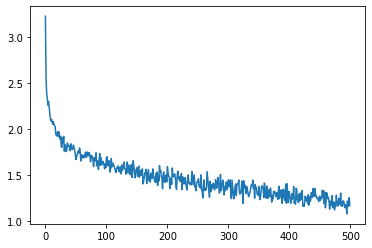

In [30]:
#plot the loss
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [31]:
print(evaluate('Th', 250, temperature=0.8))

This great Shallow, it goodly pity too Part
Hot hers to some that devilt be twent for the wall;
And fore bear the world back lady, that,
Or master while till fair, ence that go
so eyes to furselland what this soldierts of varle,
To run a dortune of mis


In [33]:
print(evaluate('Th', 250, temperature=0.2))

Think is my man with me not without his dish,
To make the first to dinner to the sight which me was to lift with the earth,
While do not so much my would be seem the fields to each bear to the sleeping of the saying of the sleep your lover
As like a wa


In [34]:
print(evaluate('Th', 250, temperature=1.4))

Thyou lomay ishs; heast, which to love a luard
for expose I servanniBan? hoLsand I must Sunkoly
A thy hea EtoU:
Sir, Oh, a'le illSumed which knister's a?
NATO:,
Witse Samived I'll tell-bdamen, dow from dair:
A smy dip: Master not, and suppliny woman
Sh
